In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.nn.utils import spectral_norm
import time
import math
import datetime
import h5py
from IPython.display import HTML
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn
from tqdm import tqdm 
import torchvision
from torchvision.datasets import CIFAR10
from torch import nn, optim
import cv2
from scipy import linalg
import sys
sys.path.append('/content/drive/Shareddrives/CS523FinalProject/FID')
from Inception_model import InceptionV3

from google.colab import drive

drive.mount('/content/gdrive')

from PIL import Image

Mounted at /content/gdrive


In [6]:
# load inception model
model = InceptionV3(resize_input = True)
model.eval()

InceptionV3(
  (blocks): ModuleList()
  (block): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicConv2d(
      (conv): Conv2d(80, 192, kern

In [7]:
# define directory for images
dir_og = '/content/gdrive/Shareddrives/CS523FinalProject/data/valImages/'
dir_bilinear = '/content/gdrive/Shareddrives/CS523FinalProject/FID/up_bilinear_img'
dir_bicubic = '/content/gdrive/Shareddrives/CS523FinalProject/FID/up_bicubic_img'
dir_nn = '/content/gdrive/Shareddrives/CS523FinalProject/FID/up_nearest_img'
dir_lanczos = '/content/gdrive/Shareddrives/CS523FinalProject/FID/up_lanczos_img'
dir_pretrained = '/content/gdrive/Shareddrives/CS523FinalProject/FID/preweight_gen'
dir_trained = '/content/gdrive/Shareddrives/CS523FinalProject/FID/trained_weight_gen'

In [8]:
# get embeddings
to_tensor = T.ToTensor()

embed_og = []
embed_bilinear = []
embed_bicubic = []
embed_nn = []
embed_lanczos = []
embed_pretrained = []
embed_trained = []
for ii in range(1,283):
  img_og = to_tensor(Image.open(dir_og+f'img_{ii}.png'))[0:3]
  img_bilinear = to_tensor(Image.open(dir_bilinear+f'/img{ii}.png'))
  img_bicubic = to_tensor(Image.open(dir_bicubic+f'/img{ii}.png'))
  img_nn = to_tensor(Image.open(dir_nn+f'/img{ii}.png'))
  img_lanczos = to_tensor(Image.open(dir_lanczos+f'/img{ii}.png'))
  img_pretrained = to_tensor(Image.open(dir_pretrained+f'/img{ii}.png'))
  img_trained = to_tensor(Image.open(dir_trained+f'/img{ii}.png'))

  embed_og.append(model(img_og.unsqueeze(0)).squeeze(0).numpy())
  embed_bilinear.append(model(img_bilinear.unsqueeze(0)).squeeze(0).numpy())
  embed_bicubic.append(model(img_bicubic.unsqueeze(0)).squeeze(0).numpy())
  embed_nn.append(model(img_nn.unsqueeze(0)).squeeze(0).numpy())
  embed_lanczos.append(model(img_lanczos.unsqueeze(0)).squeeze(0).numpy())
  embed_pretrained.append(model(img_pretrained.unsqueeze(0)).squeeze(0).numpy())
  embed_trained.append(model(img_trained.unsqueeze(0)).squeeze(0).numpy())

embed_og = np.array(embed_og)
embed_bilinear = np.array(embed_bilinear)
embed_bicubic = np.array(embed_bicubic)
embed_nn = np.array(embed_nn)
embed_lanczos = np.array(embed_lanczos)
embed_pretrained = np.array(embed_pretrained)
embed_trained = np.array(embed_trained)


embed_og = embed_og.reshape(embed_og.shape[0:2])
embed_bilinear = embed_bilinear.reshape(embed_bilinear.shape[0:2])
embed_bicubic = embed_bicubic.reshape(embed_bicubic.shape[0:2])
embed_nn = embed_nn.reshape(embed_nn.shape[0:2])
embed_lanczos = embed_lanczos.reshape(embed_lanczos.shape[0:2])
embed_pretrained = embed_pretrained.reshape(embed_pretrained.shape[0:2])
embed_trained = embed_trained.reshape(embed_trained.shape[0:2])

In [9]:
# calculate mean and covrainace matrix
og_mu, og_sigma = embed_og.mean(axis=0), np.cov(embed_og, rowvar=False)
bilinear_mu, bilinear_sigma = embed_bilinear.mean(axis=0), np.cov(embed_bilinear, rowvar=False)
bicubic_mu, bicubic_sigma = embed_bicubic.mean(axis=0), np.cov(embed_bicubic, rowvar=False)
nn_mu, nn_sigma = embed_nn.mean(axis=0), np.cov(embed_nn, rowvar=False)
lanczos_mu, lanczos_sigma = embed_lanczos.mean(axis=0), np.cov(embed_lanczos, rowvar=False)
pretrained_mu, pretrained_sigma = embed_pretrained.mean(axis=0), np.cov(embed_pretrained, rowvar=False)
trained_mu, trained_sigma = embed_trained.mean(axis=0), np.cov(embed_trained, rowvar=False)

In [10]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
  if not np.isfinite(covmean).all():# make sure cov matrix is not singular
        print('Adding Eps')
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
  if np.iscomplexobj(covmean): #make sure only real part
        covmean = covmean.real

  tr_covmean = np.trace(covmean)
  mu_diff = mu1-mu2
  return (mu_diff.dot(mu_diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [11]:
print('Bilinear FID:',calculate_fid(og_mu, og_sigma, bilinear_mu, bilinear_sigma))
print('Bicubic FID:',calculate_fid(og_mu, og_sigma, bicubic_mu, bicubic_sigma))
print('NN FID:',calculate_fid(og_mu, og_sigma, nn_mu, nn_sigma))
print('lanczos FID:',calculate_fid(og_mu, og_sigma, lanczos_mu, lanczos_sigma))
print('pretrained FID:',calculate_fid(og_mu, og_sigma, pretrained_mu, pretrained_sigma))
print('trained FID:',calculate_fid(og_mu, og_sigma, trained_mu, trained_sigma))

Bilinear FID: 190.12648427982566
Bicubic FID: 179.07273453657433
NN FID: 171.35758231280062
lanczos FID: 178.09276974152954
pretrained FID: 192.79623429963243
trained FID: 109.73713659142186


In [12]:
from numpy.random import random
act1 = random(10*2048)
act1 = act1.reshape((10,2048))
act2 = random(10*2048)
act2 = act2.reshape((10,2048))

mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

print(sigma2.shape)
# fid between act1 and act1
fid = calculate_fid(mu1,sigma1, mu1, sigma1)
print('FID (same): %.5f' % fid)
# fid between act1 and act2
fid = calculate_fid(mu1,sigma1, mu2, sigma2)
print('FID (different): %.5f' % fid)

(2048, 2048)
FID (same): -0.00015
FID (different): 359.58058


In [13]:
print(embed_nn[-1])
print(embed_bicubic[-1])

[0.25421077 0.02323732 0.06817972 ... 0.07305514 0.02470449 0.37486312]
[0.30346018 0.01050766 0.05228423 ... 0.10379041 0.05017694 0.36834478]


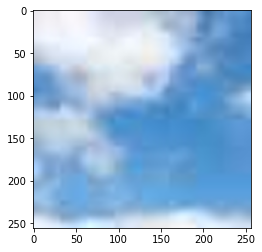

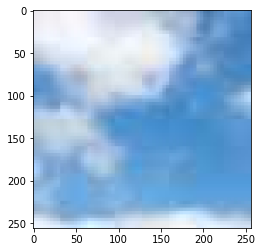

In [14]:
to_pil = T.ToPILImage()
ii = 1
img1 = img_bicubic
plt.imshow(to_pil(img1))
plt.figure()
img2 = img_nn
plt.imshow(to_pil(img2))

In [15]:
print(model(img_nn.unsqueeze(0)).squeeze(0).numpy().reshape(1,2048))
print(model(img_bicubic.unsqueeze(0)).squeeze(0).numpy().reshape(1,2048))
print(model(img_lanczos.unsqueeze(0)).squeeze(0).numpy().reshape(1,2048))

[[0.25421077 0.02323732 0.06817972 ... 0.07305514 0.02470449 0.37486312]]
[[0.30346018 0.01050766 0.05228423 ... 0.10379041 0.05017694 0.36834478]]
[[0.27904683 0.00978714 0.05203199 ... 0.09278763 0.04362709 0.35542515]]
